## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [2]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [3]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 79672
The length of the data without the rows with nan value is: 79661


In [4]:
data_features = original_data.copy()
data_features['adopted'] = data_features.outcome_type.apply(lambda o: 1 if o =='Adoption' else 0)
data_features.drop('outcome_type', axis=1, inplace=True)
data_features.sample(10)

,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,adopted
62535,Neutered Male,3.000000,Dog,Normal,Stray,Neutered Male,3.000000,2017,2.0,7.465972,0
54637,Intact Female,0.164384,Cat,Nursing,Stray,Intact Female,0.076712,2016,1.0,35.069444,0
42201,Neutered Male,2.000000,Dog,Normal,Stray,Neutered Male,2.000000,2015,2.0,3.152083,0
35840,Intact Male,0.005479,Cat,Nursing,Stray,Intact Male,0.005479,2015,1.0,0.443056,0
64450,Intact Female,2.000000,Dog,Normal,Stray,Intact Female,2.000000,2017,1.0,0.054167,0
33606,Unknown,0.010959,Cat,Normal,Stray,Unknown,0.010959,2015,1.0,0.024306,0
78222,Neutered Male,0.739726,Dog,Normal,Stray,Intact Male,0.575342,2018,1.0,39.247917,1
37034,Neutered Male,0.082192,Dog,Normal,Stray,Intact Male,0.082192,2015,1.0,6.166667,1
48923,Neutered Male,11.000000,Dog,Normal,Stray,Neutered Male,11.000000,2016,2.0,4.989583,1
47220,Neutered Male,2.000000,Dog,Normal,Stray,Intact Male,2.000000,2016,1.0,3.963889,1


In [5]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [6]:
train, test = split_set(data_features)

In [7]:
categorical_columns = ['sex_upon_outcome', 'animal_type', 'intake_condition',
                       'intake_type', 'sex_upon_intake']
train_categorical = pd.get_dummies(train, columns=categorical_columns)

test_categorical = pd.get_dummies(test, columns=categorical_columns)[train_categorical.columns]

train_label=train_categorical.adopted
train_features = train_categorical.drop('adopted', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test_categorical.adopted
test_features = test_categorical.drop('adopted', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 63804
Length of the test dataset : 15857


In [8]:
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

train_features_std.head()

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,2.712269,2.730904,1.198089,-0.277915,-0.389857,-0.363342,-0.372594,1.345262,-0.685389,-0.306645,...,-0.056635,-0.481980,-0.259515,0.652885,-0.214678,-0.650664,-0.682378,2.290421,-0.401457,-0.306645
1,1.677084,1.693224,-1.101106,1.928669,-0.373609,-0.363342,-0.372594,1.345262,-0.685389,-0.306645,...,-0.056635,-0.481980,3.853279,-1.531639,-0.214678,-0.650664,-0.682378,2.290421,-0.401457,-0.306645
2,1.332023,1.347331,-1.101106,4.135254,-0.377137,-0.363342,-0.372594,1.345262,-0.685389,-0.306645,...,-0.056635,-0.481980,3.853279,-1.531639,-0.214678,-0.650664,-0.682378,2.290421,-0.401457,-0.306645
3,2.712269,2.730904,-1.101106,-0.277915,-0.283833,-0.363342,-0.372594,1.345262,-0.685389,-0.306645,...,-0.056635,2.074742,-0.259515,-1.531639,-0.214678,-0.650664,-0.682378,2.290421,-0.401457,-0.306645
4,4.437577,4.460371,-1.867504,-0.277915,-0.383018,-0.363342,-0.372594,-0.743338,1.459002,-0.306645,...,-0.056635,-0.481980,-0.259515,0.652885,-0.214678,-0.650664,-0.682378,-0.436594,2.490885,-0.306645


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [9]:
logreg = LogisticRegression(solver='lbfgs', max_iter=10000)

model = logreg.fit(train_features_std, train_label)

preds = model.predict_proba(test_features_std)

Accuracy = 0.82
PrecisionP = 0.76
RecallP = 0.83
F1-scoreP= 0.79
PrecisionN = 0.87
RecallN = 0.82
F1-scoreN= 0.84


(    POS   NEG
 0  5445  1132
 1  1688  7592,
 np.float64(0.8221605600050451),
 np.float64(0.7633534277302678),
 np.float64(0.8278850539759769),
 np.float64(0.7943107221006563),
 np.float64(0.8702430077945896),
 np.float64(0.8181034482758621),
 np.float64(0.8433681404132415))

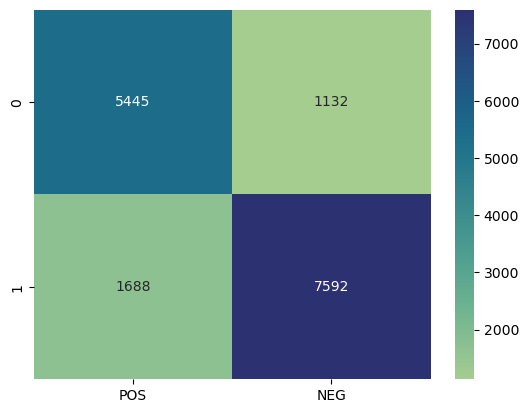

In [32]:
def confusion_matrix(test_preds, test_labels, threshold, plot = True, prints = True):
    preds = (test_preds[:,1] > threshold).astype(int)
    TP = np.sum(np.logical_and(preds==1, test_labels==1))
    TN = np.sum(np.logical_and(preds==0, test_labels==0))
    FP = np.sum(np.logical_and(preds==1, test_labels==0))
    FN = np.sum(np.logical_and(preds==0, test_labels==1))

    d = {"POS": [TP,FP], "NEG": [FN, TN]}
    confusion_matrix = pd.DataFrame(d)
    if plot:
        sn.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="crest")

    accuracy = (TP + TN) / (TP + TN  + FP + FN)
    precision_pos = TP / (TP + FP) if (TP+FP) !=0 else np.nan
    recall_pos = TP / (TP + FN) if (TP+FN) !=0 else np.nan
    f1_pos = 2 * precision_pos * recall_pos / (precision_pos + recall_pos)

    precision_neg = TN / (TN + FN) if (TN+FN) !=0 else np.nan
    recall_neg = TN / (TN + FP) if (TN+FP) !=0 else np.nan
    f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg)

    if prints:
        print(f"Accuracy = {accuracy:.2f}\nPrecisionP = {precision_pos:.2f}\nRecallP = {recall_pos:.2f}\nF1-scoreP= {f1_pos:.2f}")
        print(f"PrecisionN = {precision_neg:.2f}\nRecallN = {recall_neg:.2f}\nF1-scoreN= {f1_neg:.2f}")
    return confusion_matrix, accuracy, precision_pos, recall_pos, f1_pos, precision_neg, recall_neg, f1_neg


confusion_matrix(preds, test_label, 0.5)

### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [35]:
ths = np.linspace(0,1,100)
accs = []
precsP = []
recsP = []
f1sP = []
precsN = []
recsN = []
f1sN = []

for t in ths:
    cm, acc, precP, recP, f1P,precN, recN, f1N = confusion_matrix(preds, test_label, t, plot = False, prints = False)
    accs.append(acc)
    precsP.append(precP)
    recsP.append(recP)
    f1sP.append(f1P)
    precsN.append(precN)
    recsN.append(recN)
    f1sN.append(f1N)

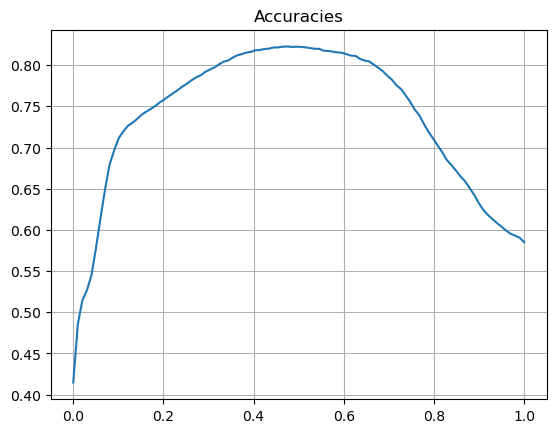

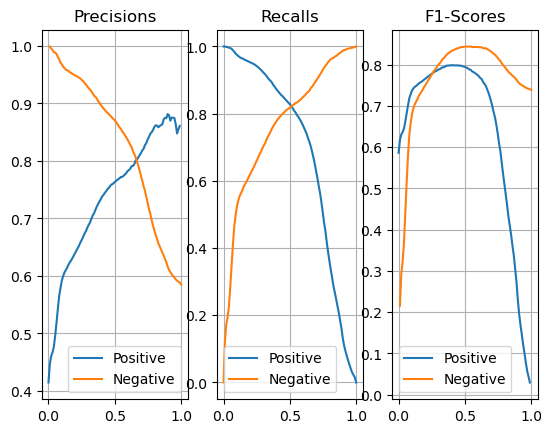

In [40]:
plt.plot(ths, accs)
plt.grid()
plt.title("Accuracies")
plt.show()

plt.subplot(131)
plt.plot(ths, precsP, label = "Positive")
plt.plot(ths, precsN, label = "Negative")
plt.title("Precisions")
plt.grid()
plt.legend()
plt.subplot(132)
plt.plot(ths, recsP, label = "Positive")
plt.plot(ths, recsN, label = "Negative")
plt.title("Recalls")
plt.grid()
plt.legend()
plt.subplot(133)
plt.plot(ths, f1sP, label = "Positive")
plt.plot(ths, f1sN, label = "Negative")
plt.title("F1-Scores")
plt.grid()
plt.legend()
plt.show()

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.


## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95